# Explaining Image Captioning (Image to Text) using Open Source Image Captioning Model and Partition Explainer

This notebook demonstrates how to use SHAP for explaining output of image captioning models i.e. given an image, model outputs a caption for the image. 

Here, we are using a pre-trained open source model from https://github.com/ruotianluo/ImageCaptioning.pytorch to get image captions. All pre-trained models are available at https://github.com/ruotianluo/ImageCaptioning.pytorch/blob/master/MODEL_ZOO.md. Particularly, this notebook uses the model trained with ResNet101 features linked under "FC+new_self_critical" model & metrics https://drive.google.com/open?id=1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0.

### Limitations 

1. To explain image captions, we are segmenting images along axes (i.e. super pixels/partitions of halves, quarters, eights...); An alternate approach/future improvement could be to semantically segment images instead of axis-aligned partitioning and produce SHAP explanations using segments, instead of super pixels. https://github.com/slundberg/shap/issues/1738 

2. We are using transformer language model (ex. distilbart) to do alignment scoring between given image and masked image captions, assuming an external model is a good surrogate for the original captioning model's language head. By using the captioning model's own language head, we could eliminate this assumption and remove the dependency. (ex. refer to text2text notebook examples). For more details, refer to the "Load language model and tokenizer" section below. https://github.com/slundberg/shap/issues/1739 

3. The more evaluations used to generate explanations, longer it takes for SHAP to run. But, increasing the number of evaluations increases the granularity of the explanations (300-500 evaluations often produce detailed maps, but fewer or more are also often reasonable). Refer to "Create an explainer object using wrapped model and image masker" section below for more details.

### Setting up open source model

##### Note: It is important to follow set up instructions exactly as given below to ensure notebook runs.

1. Clone https://github.com/ruotianluo/ImageCaptioning.pytorch repo. In a terminal type: 'git clone https://github.com/ruotianluo/ImageCaptioning.pytorch'.

2. Change below PREFIX variable to have absolute path of your ImageCaptioning.pytorch folder. This is an important step to ensure all file paths are accessed correctly.

3. Download the following files and place them in the folders as given:
    1. "model-best.pth": download from here https://drive.google.com/drive/folders/1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0  and place in the cloned directory.
    2. "infos_fc_nsc-best.pkl": download from here https://drive.google.com/drive/folders/1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0 and place in the cloned directory
    3. "resnet101": download from here https://drive.google.com/drive/folders/0B7fNdx_jAqhtbVYzOURMdDNHSGM and place in the cloned directory under 'data/imagenet_weights' folder. Create 'imagenet_weights' folder under 'data' directory if it doesn't exist. 

4. In a terminal, navigate to the cloned folder and type "python -m pip install -e ." or in a cell in jupyter notebook "!python -m pip install -e ." to install the module. 

5. Restart and clear kernel output to run this notebook. 

6. *Optional*: After running cells below in "Load sample data" section which loads sample data and creates a './test_images/' folder, try "python tools/eval.py --model model-best.pth --infos_path infos_fc_nsc-best.pkl --image_folder test_images --num_images 10" command in a terminal to verify that the installation was succesful. If it fails, please install any missing packages. ex. if 'lmdbdict' package is missing, try installing using "pip install git+https://github.com/ruotianluo/lmdbdict.git". If captions are shown in terminal output, then the installation was successful. 

    ##### Note: If these commands are being tested in a jupyter notebook, append ! in front of the commands. ex. "!python -m pip install -e ."

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ruotianluo/ImageCaptioning.pytorch

In [ ]:
%cd /content/ImageCaptioning.pytorch
!python -m pip install -e .

In [ ]:
pip install shap==0.38.1

In [ ]:
# !pip install shap
!pip install lmdbdict
!pip install transformers

In [ ]:
!unzip /content/drive/MyDrive/Slake.zip -d /content/data

In [ ]:
!unzip /content/drive/MyDrive/Bert_Embeddings_train.zip -d /content/data

In [ ]:
!unzip /content/drive/MyDrive/slake_knowledge_embeddings.zip -d /content/data

In [1]:
import json

with open('/content/data/Slake1.0/train.json', 'r', encoding='utf-8') as file:
    data_qa = json.load(file)

### data to input

In [36]:
data_qa[700]

{'answer': 'Yes',
 'answer_type': 'CLOSED',
 'base_type': 'vqa',
 'content_type': 'Organ',
 'img_id': 201,
 'img_name': 'xmlab201/source.jpg',
 'location': 'Abdomen',
 'modality': 'CT',
 'q_lang': 'en',
 'qid': 700,
 'question': 'Does the picture contain liver?',
 'triple': ['vhead', '_', '_']}

In [37]:
for d in data_qa:
  if d['qid'] == 700:
    print(d)
    image_id = d['img_id']
    question_id = d['qid']

{'img_id': 201, 'img_name': 'xmlab201/source.jpg', 'question': 'Does the picture contain liver?', 'answer': 'Yes', 'q_lang': 'en', 'location': 'Abdomen', 'modality': 'CT', 'answer_type': 'CLOSED', 'base_type': 'vqa', 'content_type': 'Organ', 'triple': ['vhead', '_', '_'], 'qid': 700}


In [41]:
!rm /content/ImageCaptioning.pytorch/test_images/*
!cp /content/data/Slake1.0/imgs/xmlab201/source.jpg /content/ImageCaptioning.pytorch/test_images

### Load sample data 

In [38]:
import os
import shap
from shap.utils.image import *

In [39]:
#change PREFIX to have absolute path of cloned directory of ImageCaptioning.pytorch 
PREFIX = r"/content/ImageCaptioning.pytorch"
os.chdir(PREFIX)

# directory of images to be explained 
DIR = './test_images/' 
# creates or empties directory if it already exists
make_dir(DIR)
add_sample_images(DIR)

# directory for saving masked images
DIR_MASKED = './masked_images/'

In [40]:
import captioning
import captioning.models as models
import captioning.utils.eval_utils as eval_utils
import captioning.utils.misc as utils
import captioning.modules.losses as losses
from captioning.data.dataloader import *
from captioning.data.dataloaderraw import *
import gc
import sys
import torch
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

# to suppress verbose output from open source model
from contextlib import contextmanager
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

### Own model

In [42]:
%cd /content/drive/MyDrive/VQACode_2/VQACode1

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pandas as pd
import time
import pathlib
from utils.load_data_QA import SlakeDataLoaderTrain
#from utils.load_data_overall import Dataloader
from utils.evaluation import AnswerEvaluator
from utils.training_toolkit import CustomSchedule, loss_function
from models.Transformer.transformers import VQATransformer
from models.Transformer.masks import create_masks, create_kn_mask

/content/drive/MyDrive/VQACode_2/VQACode1


#### Set up Arguments

In [43]:
num_layers=2
d_model=512
num_heads=8
dff=2048
maximum_position_encoding=10000
EPOCHS = 50
batch_size = 64
cnn_type = 'resnet'
embedding = 'bert'  # choose from ['w2v', 'bioelmo', 'biobert', 'bluebert', 'large_biobert', 'elmo']
data_augmentation = True


In [44]:
####### DO NOT CHANGE VALUES OF THIS BLOCK IF YOU ARE NOT THE DEVELOPER ##########

check_point_path = './check_point/transformer/QA/' + embedding +'/' + cnn_type + '_' + str(num_layers)
saving_folder = './QA_results/transformer/' + embedding + '/'
save_result_path = saving_folder + cnn_type + '_' + str(num_layers) + '.csv'

kn_input = 75
emb_size = 1024
pe_output = 36 + 1
MAX_LENGTH = pe_output
if cnn_type == 'inception':
    img_shape = [299, 299]
    img_padding = tf.TensorShape([299, 299, 3])
if cnn_type in ['resnet', 'resnet_v2', 'dense_net', 'vgg19']:
    img_shape = None
    img_padding = tf.TensorShape([224, 224, 3])

if embedding == 'bioelmo':
    pe_input = 38
elif embedding == 'elmo':
    pe_input = 42
elif embedding == 'biobert':
    pe_input = 21
    emb_size = 1024
elif embedding == 'bluebert':
    pe_input = 69
elif embedding == 'large_biobert':
    pe_input = 60  
elif embedding == 'w2v':
    pe_input = 48
    emb_size = 200
elif embedding == 'bert':
    pe_input = 72
    emb_size = 1024
else:
    raise TypeError("Wrong embedding type")
    
if data_augmentation:
    aug = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip(),
                               tf.keras.layers.experimental.preprocessing.RandomRotation(0.05)])

#### Create Datasets

In [45]:
train_loader = SlakeDataLoaderTrain('/content/data', embedding)
train_dataset, train_tokenizer = train_loader.create_dataset('QA')
batched_train_set = train_dataset.padded_batch(batch_size, padded_shapes=((img_padding, tf.TensorShape([pe_input, emb_size]), tf.TensorShape([kn_input, 1024])),
  
                                                                 tf.TensorShape([pe_output-1]), []), drop_remainder=True)

QA: 4919
Load: QA


In [46]:
vocab_size=len(train_tokenizer.index_word) 
print(vocab_size)

251


### 

#### 

#### Define Models and Related Functions 

In [47]:
transformer = VQATransformer(num_layers, d_model, num_heads, dff, vocab_size, pe_input, pe_output,
                          pretrained_cnn_type=cnn_type)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, check_point_path, max_to_keep=5)

In [48]:
def evaluate(question, img, kn):
    end_token = tf.constant(train_tokenizer.texts_to_sequences(['<end>']), tf.int32)
    output = dec_input = tf.expand_dims([train_tokenizer.word_index['<start>']], 0)
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            question, output)
        predictions, attention_weights = transformer(question,
                                    img,
                                    kn,
                                    output,
                                    False,
                                    enc_padding_mask,
                                    combined_mask,
                                    dec_padding_mask)

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

#### Predict

In [ ]:
# ckpt_manager.checkpoints

In [ ]:
# ckpt.restore('/content/drive/MyDrive/VQACode/check_point/transformer/QA/bioelmo/resnet_2/ckpt-1').expect_partial()

In [ ]:
# transformer

In [49]:
ckpt_manager.restore_or_initialize()

'./check_point/transformer/QA/bert/resnet_2/ckpt-1'

In [50]:
import numpy as np
image_size = [224, 224]
def load_and_preprocess_image(path):
    image = tf.io.read_file(path) # read image file
    image = tf.image.decode_jpeg(image, channels=3) # decode image
    image = tf.image.resize(image, image_size)
    return image
def load_question_features(path):
    return np.load(path)

In [51]:
img_input = tf.convert_to_tensor(load_and_preprocess_image('/content/data/Slake1.0/imgs/xmlab201/source.jpg'))
ques_input = tf.convert_to_tensor(load_question_features('/content/data/ques_embeddings/700.npy'))
kg_input = tf.convert_to_tensor(load_question_features('/content/data/knowledge_embeddings/700.npy'))

ques_input = tf.pad(ques_input,[[0,pe_input-ques_input.shape[0]],[0,0]],"CONSTANT")
kg_input = tf.pad(kg_input,[[0,kn_input-kg_input.shape[0]],[0,0]],"CONSTANT")

img_input = tf.expand_dims(img_input, axis=0)
ques_input = tf.expand_dims(ques_input, axis=0)
kg_input = tf.expand_dims(kg_input, axis=0)

# Answer
prediction, attention = evaluate(ques_input, img_input, kg_input)

p = prediction.numpy()
predict_answer = [train_tokenizer.index_word[i] for i in p][1:]
predict_answer = " ".join(predict_answer)
print(predict_answer)

yes


### get caption

In [52]:
# create function to get caption using model created above
def get_caption(model, image_folder, batch_size):
    img_input = tf.convert_to_tensor(load_and_preprocess_image(image_folder))
    ques_input = tf.convert_to_tensor(load_question_features('/content/data/ques_embeddings/700.npy'))
    kg_input = tf.convert_to_tensor(load_question_features('/content/data/knowledge_embeddings/700.npy'))

    ques_input = tf.pad(ques_input,[[0,pe_input-ques_input.shape[0]],[0,0]],"CONSTANT")
    kg_input = tf.pad(kg_input,[[0,kn_input-kg_input.shape[0]],[0,0]],"CONSTANT")

    img_input = tf.expand_dims(img_input, axis=0)
    ques_input = tf.expand_dims(ques_input, axis=0)
    kg_input = tf.expand_dims(kg_input, axis=0)

    # Answer
    prediction, attention = evaluate(ques_input, img_input, kg_input)

    p = prediction.numpy()
    predict_answer = [train_tokenizer.index_word[i] for i in p][1:]
    predict_answer = " ".join(predict_answer)
    return predict_answer

### Load data

'./test_images/' is the folder of images that will be explained. './test_images/' directory has been created for you and sample images needed to replicate examples shown in the notebook are already placed in the directory. 

### Note: **Replace or add images that you would like to be explained(tested) in the './test_images/' folder.**

In [53]:
%cd /content/ImageCaptioning.pytorch

/content/ImageCaptioning.pytorch


In [54]:
# checks if test images folder exists and if it has any files
if not is_empty(DIR):

    X = []
    print("Loading data...")
    files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, f))]
    for file in files:
        path_to_image = os.path.join(DIR, file)
        print("Loading image:", file)
        X.append(load_image(path_to_image))
    with suppress_stdout():
        captions = get_caption(transformer, path_to_image, 5)
    if len(X) > 1:
       print("\nCaptions are...", *captions, sep = "\n")
    else:
        print("\nCaption is...", captions)
    print("\nNumber of images in test dataset:", len(X))

Loading data...
Loading image: source.jpg

Caption is... yes

Number of images in test dataset: 1


### Load language model and tokenizer

Transformer Language Model 'distilbart' and tokenizer are being used here to tokenize the image caption. This makes the image to text scenario similar to a multi-class problem. 'distilbart' is used to do alignment scoring between the original image caption and masked image captions being generated i.e. how does the probability of getting the original image caption change when the context of a masked image caption is given? (a.k.a. we are teacher forcing 'distilbart' to always produce the original image caption for the masked images and getting change in logits for each tokenized word in the caption as part of the process).

**Note**: We are using 'distilbart' here because during experimentation process we found it to give the most meaningful explanations for images. We have compared with other language models such as 'openaigpt' and 'distilgpt2'. Please feel free to explore with other language models of your choice and compare the results. 

In [55]:
# load transformer language model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

# from transformers import OpenAIGPTTokenizer, OpenAIGPTModel

# tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
# model = OpenAIGPTModel.from_pretrained('openai-gpt')

In [56]:
captions = 'yes'
tokenizer.encode(captions)

[0, 10932, 2]

### Create an explainer object using wrapped model and image masker

Various options for explainer object to experiment with:

1. **mask_value**      : Image masker uses an inpainting technqiue by default for masking (i.e. mask_value = "inpaint_ns"). There are alternate masking options available for blurring/inpainting  such as "inpaint_telea" and "blur(kernel_xsize, kernel_xsize)". Note: Different explanations can be generated by different masking options.

2. **max_evals**       : Number of evaluations done of the underlying model to get SHAP values. Recommended number of evaluations is 300-500 to get explanations with meaningful granularity of super pixels. More the number of evaluations, more the granularity but also increases run-time. Default is set to 300 evals. 

3. **batch_size**      : Number of masked images to be evaluated at once. Default size is set to 50. 

4. **fixed_context**   : Masking technqiue used to build partition tree with options of '0', '1' or 'None'. 'fixed_context = None' is the best option to generate meaningful results but it is relatively slower than fixed_context = 0 or 1 because it generates a full partition tree. Default option is set to 'None'. 

In [57]:
# setting values for logging/tracking variables
make_dir(DIR_MASKED)
image_counter = 0 
mask_counter = 0 


# define function f which takes input (masked image) and returns caption for it 
def f(x): 
    global mask_counter
    
    # emptying masked images directory 
    make_dir(DIR_MASKED)

    # saving masked array of RGB values as an image in masked_images directory
    path_to_image = os.path.join(DIR_MASKED, "{0}_{1}.png".format(image_counter, mask_counter))
    save_image(x, path_to_image) 
    
    # getting caption of masked image 
    with suppress_stdout():
        caption = get_caption(transformer, path_to_image, 5) 
    mask_counter += 1 
    
    return caption

# function to take a list of images and parameters such as masking option, max evals etc. and return shap_values_objects
def run_masker(X, mask_value = "inpaint_ns", max_evals = 300, batch_size = 50, fixed_context = None):
    """
    Function to take a list of images and parameters such max evals etc. and return shap explanations (shap_values) for test images(X).
    Paramaters
    ----------
    X               : list of images which need to be explained
    mask_value      : various masking options for blurring/inpainting such as "inpaint_ns", "inpaint_telea" and "blur(pixel_size, pixel_size)"
    max_evals       : number of evaluations done of the underlying model to get SHAP values 
    batch_size      : number of masked images to be evaluated at once 
    fixed_context   : masking technqiue used to build partition tree with options of '0', '1' or 'None'
    Output
    ------
    shap_values_list: list of shap_values objects generated for the images
    """
    global image_counter
    global mask_counter
    shap_values_list = []

    for index in range(len(X)): 

        # define a masker that is used to mask out partitions of the input image based on mask_value option
        masker = shap.maskers.Image(mask_value, X[index].shape)

        # wrap model with TeacherForcingLogits class
        wrapped_model = shap.models.TeacherForcingLogits(f, similarity_model=model, similarity_tokenizer=tokenizer)

        # build a partition explainer with wrapped_model and image masker
        explainer = shap.Explainer(wrapped_model, masker) 

        # compute SHAP values - here we use max_evals no. of evaluations of the underlying model to estimate SHAP values
        shap_values = explainer(np.array(X[index:index+1]), max_evals = max_evals, batch_size = batch_size, fixed_context = fixed_context)
        shap_values_list.append(shap_values)

        # output plot
        shap_values.output_names[0] = [word.replace('Ġ', '') for word in shap_values.output_names[0]]
        shap.image_plot(shap_values)

        # setting values for next iterations
        mask_counter = 0
        image_counter += 1
    
    return shap_values_list

In [58]:
X[0].shape

(512, 512, 3)

### SHAP explanation for test images

explainers.Partition is still in an alpha state, so use with caution...


Partition explainer: 2it [02:13, 66.95s/it]               


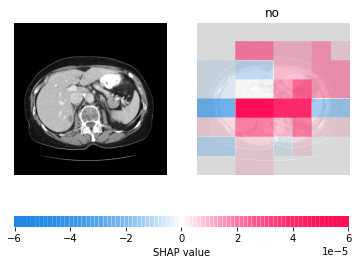

In [59]:
# SHAP explanation using masking option "blur(pixel_size, pixel_size)" for blurring
shap_values = run_masker(X, mask_value="blur(56,56)")

explainers.Partition is still in an alpha state, so use with caution...


Partition explainer: 2it [02:58, 89.43s/it]               


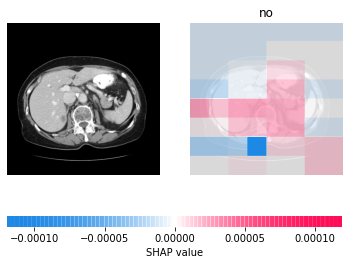

In [60]:
# SHAP explanation using masking option "inpaint_telea" for inpainting
shap_values = run_masker(X[0:1], mask_value= "inpaint_telea")

## question

###bert

In [61]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np
import json
import re
import os

tokenizer_q = AutoTokenizer.from_pretrained("bert-large-cased", do_lower_case=True)
model_q = AutoModel.from_pretrained("bert-large-cased", output_hidden_states=True)

def preprocess_sentence(w):
    w = w.lower().strip()
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z ]", "", w)
    w = w.strip()
    return w


path = '/content/bert'
if not os.path.exists(path):
    os.mkdir(path)

def get_embd(ques):
    ques_id = 1
    # ques = qa['Questions']
    after = preprocess_sentence(ques)

    marked_text1 = "[CLS] " + after + " [SEP]"
    tokenized_text1 = tokenizer_q.tokenize(marked_text1)
    indexed_tokens1 = tokenizer_q.convert_tokens_to_ids(tokenized_text1)
    segments_ids1 = [1] * len(tokenized_text1)
    tokens_tensor1 = torch.tensor([indexed_tokens1])
    segments_tensors1 = torch.tensor([segments_ids1])

    with torch.no_grad():
        # Because we set 'output_hidden_states = True', the third item will be the
        # hidden states from all layers.
        outputs1 = model_q(tokens_tensor1, segments_tensors1)
        hidden_states1 = outputs1[2]

    # Concatenate the tensors for all layers.
    # Use 'stack' to create a new dimension in the tensor.
    token_embeddings1 = torch.stack(hidden_states1, dim=0)
    # Remove dimension 1, the "batches".
    token_embeddings1 = torch.squeeze(token_embeddings1, dim=1)
    # Swap dimensions 0 and 1.（“layers” and “tokens” dimensions）
    token_embeddings1 = token_embeddings1.permute(1, 0, 2)

    token_vecs_sum1 = []

    for token in token_embeddings1:
        # Sum the vectors from the last four layers.
        sum_vec1 = torch.sum(token[-4:], dim=0)
        token_vecs_sum1.append(sum_vec1)
    token_vec = np.array([t.numpy() for t in token_vecs_sum1])
    # Write .npy file to '/content/embedding/' folder.
    np.save(os.path.join(path, str(ques_id)+'.npy'), token_vec)


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
# create function to get caption using model created above
def get_caption_txt(model, image_folder, batch_size):
    img_input = tf.convert_to_tensor(load_and_preprocess_image(image_folder))
    ques_input = tf.convert_to_tensor(load_question_features('/content/bert/1.npy'))
    kg_input = tf.convert_to_tensor(load_question_features('/content/data/knowledge_embeddings/700.npy'))

    ques_input = tf.pad(ques_input,[[0,pe_input-ques_input.shape[0]],[0,0]],"CONSTANT")
    kg_input = tf.pad(kg_input,[[0,kn_input-kg_input.shape[0]],[0,0]],"CONSTANT")

    img_input = tf.expand_dims(img_input, axis=0)
    ques_input = tf.expand_dims(ques_input, axis=0)
    kg_input = tf.expand_dims(kg_input, axis=0)

    # Answer
    prediction, attention = evaluate(ques_input, img_input, kg_input)

    p = prediction.numpy()
    predict_answer = [train_tokenizer.index_word[i] for i in p][1:]
    predict_answer = " ".join(predict_answer)
    return predict_answer

In [63]:
# Define function
def f_txt(x):
  get_embd(x)
  #sentence = get_caption_txt(transformer, '/content/ImageCaptioning.pytorch/test_images/'+str(image_id)+'.jpg', 5) 
  sentence = get_caption_txt(transformer, '/content/ImageCaptioning.pytorch/test_images/'+'source.jpg', 5) 
  return sentence

In [64]:
# wrap model with TeacherForcingLogits class
teacher_forcing_model = shap.models.TeacherForcingLogits(f_txt, similarity_model=model, similarity_tokenizer=tokenizer)
# create a Text masker
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

In [65]:
s = [
    "Does the picture contain liver?"
]
# we build an explainer by passing the model we want to explain and
# the tokenizer we want to use to break up the input strings
explainer_model_agnostic = shap.Explainer(teacher_forcing_model, masker)

# explainers are callable, just like models
shap_values_model_agnostic = explainer_model_agnostic(s)

explainers.Partition is still in an alpha state, so use with caution...


Partition explainer: 2it [00:42, 21.45s/it]               

In [66]:
shap.plots.text(shap_values_model_agnostic)

,,Does,the,picture,contain,liver,?,
yes,0.0,1.403,0.701,0.701,2.074,0.731,0.0,0.0


# predict

In [67]:
import numpy as np
image_size = [224, 224]
def load_and_preprocess_image(path):
    image = tf.io.read_file(path) # read image file
    image = tf.image.decode_jpeg(image, channels=3) # decode image
    image = tf.image.resize(image, image_size)
    return image
def load_question_features(path):
    return np.load(path)

In [68]:
img_input = tf.convert_to_tensor(load_and_preprocess_image('/content/data/Slake1.0/imgs/xmlab100/source.jpg'))
ques_input = tf.convert_to_tensor(load_question_features('/content/data/ques_embeddings/7.npy'))
kg_input = tf.convert_to_tensor(load_question_features('/content/data/knowledge_embeddings/7.npy'))

ques_input = tf.pad(ques_input,[[0,pe_input-ques_input.shape[0]],[0,0]],"CONSTANT")
kg_input = tf.pad(kg_input,[[0,kn_input-kg_input.shape[0]],[0,0]],"CONSTANT")

img_input = tf.expand_dims(img_input, axis=0)
ques_input = tf.expand_dims(ques_input, axis=0)
kg_input = tf.expand_dims(kg_input, axis=0)

# Answer
prediction, attention_tm = evaluate(ques_input, img_input, kg_input)

p = prediction.numpy()
predict_answer = [train_tokenizer.index_word[i] for i in p][1:]
predict_answer = " ".join(predict_answer)
print(predict_answer)

ct


# visualisation

In [ ]:
pip install tensor2tensor

In [70]:
E_SIZE = 8
D_SIZE = 2
def resize(np_mat, tp):
  # Sum across heads
  if tp == 'enc':
    np_mat = np_mat[0, :, :E_SIZE, :E_SIZE]
  elif tp == 'dec':
    np_mat = np_mat[0, :, :D_SIZE, :D_SIZE]
  else:
    np_mat = np_mat[0, :, :D_SIZE, :E_SIZE]
  # np_mat = np_mat[0]
  print(np_mat.shape)
  row_sums = np.sum(np_mat, axis=0)
  # Normalize
  layer_mat = np_mat / row_sums[np.newaxis, :]
  lsh = layer_mat.shape
  # Add extra dim for viz code to work.
  layer_mat = np.reshape(layer_mat, (1, lsh[0], lsh[1], lsh[2]))
  return layer_mat

enc_att = []
dec_att = []
encdec_att = []
for i in range(num_layers):
  enc_att.append(resize(attention_tm[0]['encoder_layer{}_block'.format(i + 1)],'enc'))
  dec_att.append(resize(attention_tm[1]['decoder_layer{}_block1'.format(i + 1)],'dec'))
  encdec_att.append(resize(attention_tm[1]['decoder_layer{}_block2'.format(i + 1)],'encdec'))

(8, 8, 8)
(8, 2, 2)
(8, 2, 8)
(8, 8, 8)
(8, 2, 2)
(8, 2, 8)


## 200

In [45]:
from tensor2tensor.visualization import attention
from nltk.tokenize import RegexpTokenizer

def tokenize(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence.lower())

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
  
inp_text = tokenize('Which organ is abnormal, heart or lung?')
out_text = ['<start>','heart']

# while len(inp_text) < 38:
#   inp_text.append('<PAD>')

call_html()
attention.show(inp_text, out_text, enc_att, dec_att, encdec_att)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##700

In [71]:
from tensor2tensor.visualization import attention
from nltk.tokenize import RegexpTokenizer

def tokenize(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence.lower())

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
  
inp_text = tokenize('Is the lung healthy?')
out_text = ['<start>','yes']

# while len(inp_text) < 38:
#   inp_text.append('<PAD>')

call_html()
attention.show(inp_text, out_text, enc_att, dec_att, encdec_att)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 110

In [54]:
from tensor2tensor.visualization import attention
from nltk.tokenize import RegexpTokenizer

def tokenize(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence.lower())

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
  
inp_text = tokenize('Is the lung healthy?')
out_text = ['<start>','yes']

# while len(inp_text) < 38:
#   inp_text.append('<PAD>')

call_html()
attention.show(inp_text, out_text, enc_att, dec_att, encdec_att)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7

In [58]:
from tensor2tensor.visualization import attention
from nltk.tokenize import RegexpTokenizer

def tokenize(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sentence.lower())

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
  
inp_text = tokenize('What modality is used to take this image?')
out_text = ['<start>','ct']

# while len(inp_text) < 38:
#   inp_text.append('<PAD>')

call_html()
attention.show(inp_text, out_text, enc_att, dec_att, encdec_att)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>